In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

seed=1
torch.manual_seed(seed)
np.random.seed(seed)

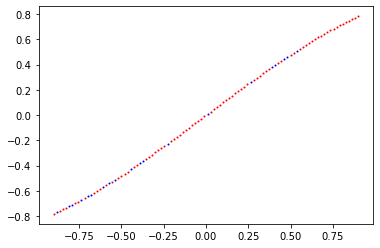

In [2]:
N=int(1e2) # number of data
x=np.linspace(-.9,.9,N)
y=np.sin(x)

idx_train=(np.random.choice(N,80,replace=0))
idx_test = np.setdiff1d(np.arange(N), idx_train)

x_train=x[idx_train]
y_train=y[idx_train]

x_test=x[idx_test]
y_test=y[idx_test]

plt.scatter(x_train,y_train,s=1,c='r')
plt.scatter(x_test,y_test,s=1,c='b')
plt.show()

In [3]:
## device choice

device = 'mps' if torch.backends.mps.is_built()  else 'cpu'


# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'mps':
    # torch.backends.mps.manual_seed_all(seed)
    torch.backends.mps.is_available()

print("learning with",device)

learning with mps


In [4]:
class Customdataset(torch.utils.data.Dataset):
    def __init__(self, x_data, y_data): # 데이터섹을 전처리
        self.x_data= x_data
        self.y_data= y_data

    def __len__(self): # 데이터섹을 총 샘플의 수를 적는 부분
        return len(self.x_data)
    
    def __getitem__(self, idx): # 데이터셋에서 특정 하나를 가져오는 함수
        x=torch.FloatTensor(self.x_data[idx])
        y=torch.FloatTensor(self.y_data[idx])
        return x,y




In [5]:
# 신경망 정의
class NN(nn.Module):
    def __init__(self, num1, num2):
        self.num1 = num1 # nodes per hidden layer
        self.num2 = num2 # number of hidden layer

        super(NN, self).__init__()
        self.layer_in = nn.Sequential(
            nn.Linear(1,self.num1),
            nn.ReLU())
        self.layer_hidden = nn.Sequential(
            nn.Linear(self.num1,self.num1),
            nn.ReLU())
        self.layer_out = nn.Sequential(
            nn.Linear(self.num1,1),
            nn.Sigmoid())

        self.hidden=nn.ModuleList()
        for i in range(self.num2):
            self.hidden.append(self.layer_hidden)
        
        
        # 가중치를 고르게하는 건데 이 잘 안돼네....
        # nn.init.xavier_uniform_(self.layer1.weight) # 지금까지는 대충 설정했는데
        # nn.init.xavier_uniform_(self.layer2.weight) # 지금까지는 대충 설정했는데

    def forward(self, x): # 순서대로 대입해서 출력하는 것뿐 
        out = self.layer_in(x)
        for layer in self.hidden:
            out = layer(out)
        out = self.layer_out(out)
        return out

model = NN(3,1).to(device)

In [6]:
## training
nodes_per_hidden_layer=5
number_of_hidden_layer=2
model = NN(nodes_per_hidden_layer,number_of_hidden_layer).to(device)
# from torchinfo import summary
# print(summary(model))
# print(model)


lr=1e-5
epochs=20
batch_size = 16

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 학습 시킬 데이터를 받고, 그러를 함수로 묶고 정리해서 _train으로 만든다.
dataset=Customdataset(x_train,y_train)
dataloader=DataLoader(dataset,batch_size=batch_size, shuffle=1)

In [7]:
cos_histroy=[]
epoch=0
while epoch<epochs:
    for batch_idx, sample in enumerate(dataloader):
        x_train,y_train=sample

        prediction=model(x_train)
        cos=F.mse_loss(prediction,y_train)

        optimizer.zero_grad()
        cos.backward()
        optimizer.step()

        print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, epochs, batch_idx+1, len(dataloader),cos.item()
        ))
    cos_histroy.append(cos.item())
    epoch+=1


TypeError: new(): data must be a sequence (got numpy.float64)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(epochs+1),cos_histroy)
plt.xlim([5,21])
plt.ylim([0,3])
plt.show()


# 이번에 도 들죽날쭋하네
# 셔플 텨져있음.

in_val=torch.FloatTensor([73,80,75])
out_val=model(in_val)
print(out_val.item())


